<a href="https://colab.research.google.com/github/kbrammer/notebooks/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image classification examples: 

[Basic classification: Classify images of clothing](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb#scrollTo=9ODch-OFCaW4)

[TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced)

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.5.0


In [29]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  # plt.imshow(img, cmap=plt.cm.binary)
  # remove extra channel dimension
  plt.imshow(np.squeeze(img), cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

def plot_single_image(i):
  plt.figure()
  plt.imshow(train_images[i])
  plt.colorbar()
  plt.grid(False)
  plt.show()

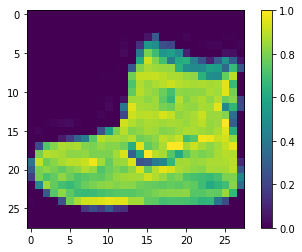

In [6]:
# train_images.shape
# len(train_labels)
# train_labels
# test_images.shape
# len(test_labels)
plot_single_image(0)

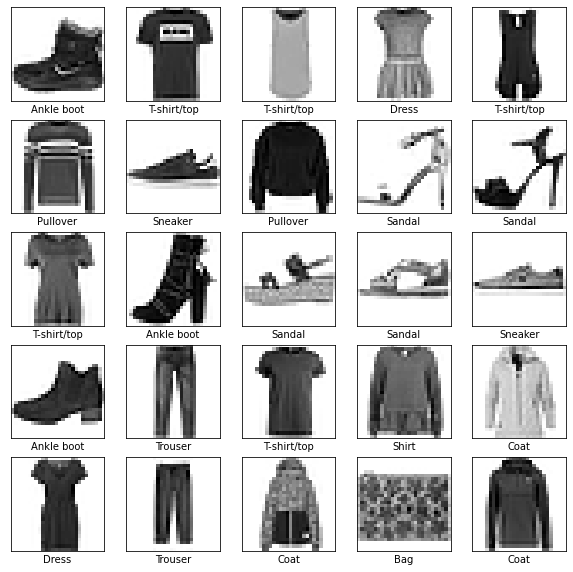

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [14]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Add a channels dimension
train_images = train_images[..., tf.newaxis].astype("float32")
test_images = test_images[..., tf.newaxis].astype("float32")

# batch and shuffle
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)


In [9]:
# build model using Keras subclassing api
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)


# Create an instance of the model
model = MyModel()

# model = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=(28, 28)),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(10)
# ])

In [10]:
# choose optimizer and loss fn
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])


In [11]:
# metrics for loss and accuracy
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [16]:
# use tf.GradientTape to train the model
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [17]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [19]:
# model.fit(train_images, train_labels, epochs=10)

EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )
  

Epoch 1, Loss: 0.24667954444885254, Accuracy: 90.8949966430664, Test Loss: 0.2804415822029114, Test Accuracy: 89.6300048828125
Epoch 2, Loss: 0.1888725459575653, Accuracy: 93.09166717529297, Test Loss: 0.2714766263961792, Test Accuracy: 90.58999633789062
Epoch 3, Loss: 0.14882402122020721, Accuracy: 94.48833465576172, Test Loss: 0.2811894416809082, Test Accuracy: 90.44000244140625
Epoch 4, Loss: 0.11207723617553711, Accuracy: 95.81999969482422, Test Loss: 0.30589306354522705, Test Accuracy: 90.58999633789062
Epoch 5, Loss: 0.08499008417129517, Accuracy: 96.8933334350586, Test Loss: 0.3394731879234314, Test Accuracy: 90.62000274658203


In [ ]:
# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

# print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.4556 - accuracy: 0.8352

Test accuracy: 0.8352000117301941


In [ ]:
# Attach a softmax layer to convert logits to probabilities
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)

predicted 3
actual tf.Tensor(3, shape=(), dtype=uint8)


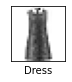

In [28]:
img = 0
# print(predictions[img])
print('predicted',np.argmax(predictions[img]))
print('actual',test_labels[img])

plt.figure(figsize=(1,1))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(np.squeeze(test_images[img]), cmap=plt.cm.binary)
plt.xlabel(class_names[test_labels[img]])
plt.show()

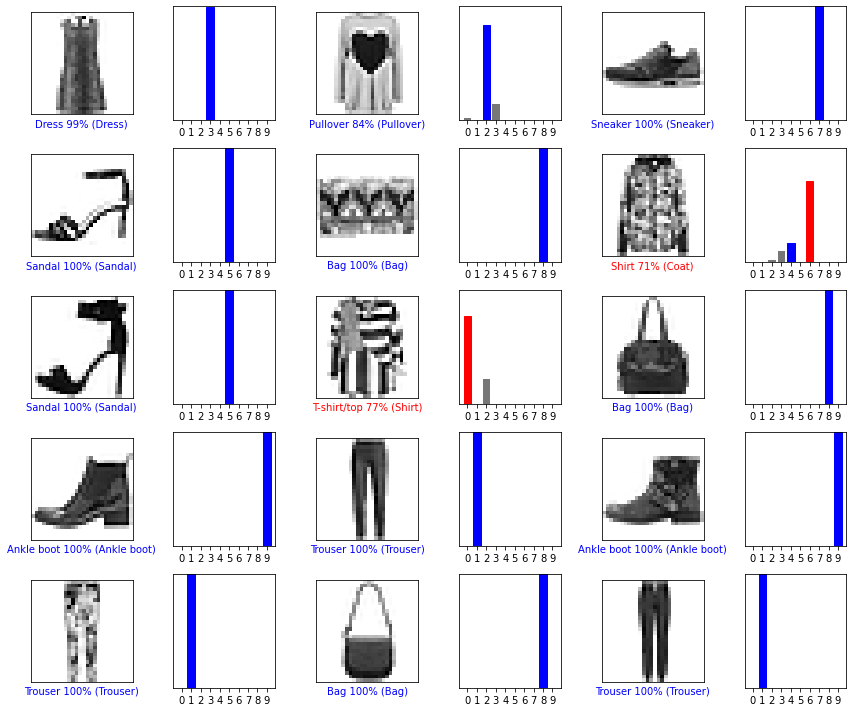

In [33]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()